In [1]:
%config IPCompleter.greedy=True

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sn
import re
import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree,preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import normalize
from imblearn.over_sampling import RandomOverSampler
from pandas.plotting import parallel_coordinates,scatter_matrix
from collections import Counter

In [3]:
def parse_file_train(filename):
    line = list()
    with open(filename) as f:
        lines = f.readline()
        counter = 1
        while lines:
            data = lines.strip('\n').split(',')
            actions = data[2:]
            player = data[0]
            race= data[1]
            line.append([player,race,actions])
            lines = f.readline()
            counter += 1
    return line


def parse_file_test(filename):
    line = list()
    with open(filename) as f:
        lines = f.readline()
        counter = 1
        while lines:
            data = lines.strip('\n').split(',')
            actions = data[1:]
            race = data[0]
            line.append([race,actions])
            lines = f.readline()
            counter += 1
    return line

In [7]:
train = parse_file_train("TRAIN.CSV")
test=parse_file_test("TEST.CSV")

In [8]:
print("La shape du jeu d'entrainement est " + str(len(train)))
print("La shape du jeu de test est " + str(len(test)))

La shape du jeu d'entrainement est 364
La shape du jeu de test est 340


In [9]:
def count_freq(line):
    player, race, actions = line
    counter = []
    c=0
    c1=0
    c2=0
    j='t0'
    tmp=0
    t0=0
    t_max=t_min=0
    matching = [s for s in actions if s.startswith('t')]
    for j in matching:
        index = actions.index(j)
        hot= 's'
        c+=actions[t0:index].count(hot)
        hot='Base'
        c+=actions[t0:index].count(hot)
        hot='SingleMineral'
        c+=actions[t0:index].count(hot)
        for i in range(10):
            hot = 'hotkey'+str(i)+'0'
            c+=actions[t0:index].count(hot)
            hot = 'hotkey'+str(i)+'1'
            c+=actions[t0:index].count(hot)
            hot = 'hotkey'+str(i)+'2'
            c+=actions[t0:index].count(hot)
        if(tmp<c):
            tmp=c
            t_max=index
            t_min=t0
        t0=index
        c=0
    t=[int(s) for s in j.split('t') if s.isdigit()]
    if(t_max and t_min and t[0]):
        tmin=t[0]/60
        for itera in range(2):
            hot='s'
            counter.append((actions.count(hot)/tmin))
            c+=actions.count(hot)
            hot='Base'
            counter.append((actions.count(hot)/tmin))
            c+=actions.count(hot)
            hot='SingleMineral'
            counter.append((actions.count(hot)/tmin))
            c+=actions.count(hot)
            for i in range(10):
                hot = 'hotkey'+str(i)+'0'
                counter.append((actions.count(hot)/tmin))
                c+=actions.count(hot)
                hot = 'hotkey'+str(i)+'1'
                counter.append((actions.count(hot)/tmin))
                c+=actions.count(hot)
                hot = 'hotkey'+str(i)+'2'
                counter.append((actions.count(hot)/tmin))
                c+=actions.count(hot)
            actions=actions[t_min:t_max]
            counter.append(c/tmin)
            c=0
    return counter

def count_freq_test(line):
    race, actions = line
    counter = []
    c=0
    c1=0
    c2=0
    j='t0'
    tmp=0
    t0=0
    t_max=t_min=0
    matching = [s for s in actions if s.startswith('t')]
    for j in matching:
        index = actions.index(j)
        hot= 's'
        c+=actions[t0:index].count(hot)
        hot='Base'
        c+=actions[t0:index].count(hot)
        hot='SingleMineral'
        c+=actions[t0:index].count(hot)
        for i in range(10):
            hot = 'hotkey'+str(i)+'0'
            c+=actions[t0:index].count(hot)
            hot = 'hotkey'+str(i)+'1'
            c+=actions[t0:index].count(hot)
            hot = 'hotkey'+str(i)+'2'
            c+=actions[t0:index].count(hot)
        if(tmp<c):
            tmp=c
            t_max=index
            t_min=t0
        t0=index
        c=0
    t=[int(s) for s in j.split('t') if s.isdigit()]
    if(t_max and t_min and t[0]):
        tmin=t[0]/60
        for itera in range(2):
            counter.append(actions.count('s')/tmin)
            c+=actions.count('s')
            counter.append(actions.count('Base')/tmin)
            c+=actions.count('Base')
            counter.append(actions.count('SingleMineral')/tmin)
            c+=actions.count('SingleMineral')
            for i in range(10):
                hot = 'hotkey'+str(i)+'0'
                counter.append(actions.count(hot)/tmin)
                c+=actions.count(hot)
                hot = 'hotkey'+str(i)+'1'
                counter.append(actions.count(hot)/tmin)
                c+=actions.count(hot)
                hot = 'hotkey'+str(i)+'2'
                counter.append(actions.count(hot)/tmin)
                c+=actions.count(hot)
            actions=actions[t_min:t_max]
            counter.append(c/tmin)
            c=0
    return counter

In [10]:
freq = list()
for line in train:
    freq.append([line[0]]+ [line[1]]+ count_freq(line))
train_dataset = pd.DataFrame(freq)

In [11]:
freq1 = list()
for line in test:
    freq1.append([line[0]]+ count_freq_test(line))
test_dataset = pd.DataFrame(freq1)

In [12]:
train_dataset.rename(columns={0:'Player',1:'Race',2:'s', 3:'Base',4:'SingleMineral',35:'TotAction',36:'mfr',37:'mfs',38:'mfb',39:'mfsm',},inplace=True)
k=5
for i in range(10):
    for j in range(3):
        train_dataset.rename(columns={k:'hotkey'+str(i)+str(j)},inplace=True)
        k+=1
k=40
for i in range(10):
    for j in range(3):
        train_dataset.rename(columns={k:'m_f_hotkey'+str(i)+str(j)},inplace=True)
        k+=1
train_dataset.head()

Player     Race          s  \
0  http://eu.battle.net/sc2/en/profile/4234852/1/...  Protoss  24.435045   
1  http://eu.battle.net/sc2/en/profile/3074362/1/...  Protoss  19.504532   
2  http://eu.battle.net/sc2/en/profile/4234852/1/...  Protoss  25.544554   
3  http://eu.battle.net/sc2/en/profile/3074362/1/...  Protoss  23.701493   
4  http://eu.battle.net/sc2/en/profile/4234852/1/...  Protoss  23.111111   

       Base  SingleMineral  hotkey00  hotkey01  hotkey02  hotkey10  hotkey11  \
0  2.392749       0.181269  0.181269       0.0  1.486405  2.283988  0.000000   
1  0.435045       0.000000  0.072508       0.0  3.009063  2.356495  0.108761   
2  2.792079       0.178218  0.178218       0.0  1.069307  1.009901  0.000000   
3  1.253731       0.000000  0.119403       0.0  2.328358  1.910448  0.059701   
4  0.222222       0.000000  0.111111       0.0  0.000000  1.111111  0.000000   

   ...  m_f_hotkey62  m_f_hotkey70  m_f_hotkey71  m_f_hotkey72  m_f_hotkey80  \
0  ...           0.0           0.0           0.0           0.0           0.0   
1  ...           0.0           0.0           0.0           0.0           0.0   
2  ...           0.0           0.0           0.0           0.0           0.0   
3  ...           0.0           0.0           0.0           0.0           0.0   
4  ...           0.0           0.0           0.0           0.0           0.0   

   m_f_hotkey81  m_f_hotkey82  m_f_hotkey90  m_f_hotkey91  m_f_hotkey92  
0           0.0           0.0           0.0           0.0      0.761329  
1           0.0           0.0           0.0           0.0      0.580060  
2           0.0           0.0           0.0           0.0      1.188119  
3           0.0           0.0           0.0           0.0      0.955224  
4           0.0           0.0           0.0           0.0      2.111111  

[5 rows x 70 columns]

In [13]:
test_dataset.rename(columns={0:'Race',1:'s', 2:'Base',3:'SingleMineral',34:'TotAction',35:'mfr',36:'mfs',37:'mfb',38:'mfsm',},inplace=True)
k=4
for i in range(10):
    for j in range(3):
        test_dataset.rename(columns={k:'hotkey'+str(i)+str(j)},inplace=True)
        k+=1
k=39
for i in range(10):
    for j in range(3):
        test_dataset.rename(columns={k:'m_f_hotkey'+str(i)+str(j)},inplace=True)
        k+=1
test_dataset.head()

Race          s      Base  SingleMineral  hotkey00  hotkey01   hotkey02  \
0     Zerg  58.148571  1.302857       0.205714  0.960000       0.0  58.080000   
1   Terran  34.842640  0.000000       0.000000  0.121827       0.0   2.010152   
2  Protoss  27.570248  0.991736       0.000000  0.049587       0.0   0.000000   
3     Zerg  64.816327  0.693878       0.081633  0.000000       0.0   0.000000   
4  Protoss  21.454545  1.909091       0.000000  0.272727       0.0   0.000000   

   hotkey10  hotkey11   hotkey12  ...  m_f_hotkey62  m_f_hotkey70  \
0  0.480000  2.125714  24.137143  ...           0.0           0.0   
1  0.852792  0.000000  20.467005  ...           0.0           0.0   
2  0.495868  0.000000  23.752066  ...           0.0           0.0   
3  2.775510  3.632653  21.428571  ...           0.0           0.0   
4  0.363636  0.636364   6.727273  ...           0.0           0.0   

   m_f_hotkey71  m_f_hotkey72  m_f_hotkey80  m_f_hotkey81  m_f_hotkey82  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   m_f_hotkey90  m_f_hotkey91  m_f_hotkey92  
0           0.0           0.0      2.537143  
1           0.0           0.0      2.253807  
2           0.0           0.0      1.388430  
3           0.0           0.0      1.224490  
4           0.0           0.0      1.545455  

[5 rows x 69 columns]

In [14]:
import pandas as pd

# Spécifiez les types de données pour chaque colonne si connu
dtype_dict = {
    'colonne1': 'int',  # remplacez 'colonne1' par le nom réel de la colonne et le type de données correct
    'colonne2': 'float',
    'colonne3': 'str',
    # ajoutez d'autres colonnes si nécessaire
}

data = pd.read_csv('TEST.CSV', dtype=dtype_dict, delimiter=',', on_bad_lines='warn')


<ipython-input-14-30dc926e0109>:11: DtypeWarning: Columns (6609,6610,6611,6612,6613,6614,6615,6616,6617,6618,6619,6620,6621,6622,6623,6624,6625,6626,6627,6628,6629,6630,6631,6632,6633,6634,6635,6636,6637,6638,6639,6640,6641,6642,6643,6644,6645,6646,6647,6648,6649,6650,6651,6652,6653,6654,6655,6656,6657,6658,6659,6660,6661,6662,6663,6664,6665,6666,6667,6668,6669,6670,6671,6672,6673,6674,6675,6676,6677,6678,6679,6680,6681,6682,6683,6684,6685,6686,6687,6688,6689,6690,6691,6692,6693,6694,6695,6696,6697,6698,6699,6700,6701,6702,6703,6704,6705,6706,6707,6708,6709,6710,6711,6712,6713,6714,6715,6716,6717,6718,6719,6720,6721,6722,6723,6724,6725,6726,6727,6728,6729,6730,6731,6732,6733,6734,6735,6736,6737,6738,6739,6740,6741,6742,6743,6744,6745,6746,6747,6748,6749,6750,6751,6752,6753,6754,6755,6756,6757,6758,6759,6760,6761,6762,6763,6764,6765,6766,6767,6768,6769,6770,6771,6772,6773,6774,6775,6776,6777,6778,6779,6780,6781,6782,6783,6784,6785,6786,6787,6788,6789,6790,6791,6792,6793,6794,6795,6796,6

In [15]:
data = pd.read_csv('TEST.CSV', delimiter=',', dtype=str)
print(data.head())


      Zerg     s       s.1       s.2  hotkey10       s.3  hotkey60       s.4  \
0   Terran     s  hotkey30  hotkey00        t5         s  hotkey32         s   
1  Protoss  Base         s         s      Base         s  hotkey20  hotkey30   
2     Zerg     s         s         s         s  hotkey20         s  hotkey40   
3  Protoss  Base         s         s      Base         s  hotkey50  hotkey30   
4   Terran     s  hotkey30         s  hotkey32         s  hotkey32         s   

   hotkey00       s.5  ... Unnamed: 6808 Unnamed: 6809 Unnamed: 6810  \
0  hotkey32         s  ...           NaN           NaN           NaN   
1  hotkey60  hotkey40  ...           NaN           NaN           NaN   
2        t5       t10  ...           NaN           NaN           NaN   
3        t5  hotkey40  ...           NaN           NaN           NaN   
4  hotkey32         s  ...           NaN           NaN           NaN   

  Unnamed: 6811 Unnamed: 6812 Unnamed: 6813 Unnamed: 6814 Unnamed: 6815  \
0          

In [16]:
for col in data.columns:
    if data[col].str.contains('http://').any():
        print(f"La colonne {col} contient des URL ou des données non numériques")


In [17]:
import pandas as pd

data = pd.read_csv('TEST.CSV', delimiter=',', low_memory=False)


In [18]:
print(data.columns)


Index(['Zerg', 's', 's.1', 's.2', 'hotkey10', 's.3', 'hotkey60', 's.4',
       'hotkey00', 's.5',
       ...
       'Unnamed: 6808', 'Unnamed: 6809', 'Unnamed: 6810', 'Unnamed: 6811',
       'Unnamed: 6812', 'Unnamed: 6813', 'Unnamed: 6814', 'Unnamed: 6815',
       'Unnamed: 6816', 'Unnamed: 6817'],
      dtype='object', length=6818)


In [21]:
dtype_dict = {
    'colonne1': 'int',    # remplacez 'colonne1' par le nom réel de la colonne et le type de données correct
    'colonne2': 'float',
    'colonne3': 'str',
    # ajoutez d'autres colonnes si nécessaire
}

data = pd.read_csv('TEST.CSV', delimiter=',', dtype=dtype_dict, low_memory=False)


In [22]:
numeric_columns = ['colonne_numerique1', 'colonne_numerique2']  # remplacez par les noms réels des colonnes numériques

for col in numeric_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

print(data.dtypes)  # Vérifiez les types de données des colonnes


Zerg             object
s                object
s.1              object
s.2              object
hotkey10         object
                  ...  
Unnamed: 6813    object
Unnamed: 6814    object
Unnamed: 6815    object
Unnamed: 6816    object
Unnamed: 6817    object
Length: 6818, dtype: object


In [23]:
def nettoyer_donnees(row):
    # Implémentez la logique de nettoyage personnalisée
    return row

data = data.apply(nettoyer_donnees, axis=1)


In [24]:
data.to_csv('CLEANED_TEST.CSV', index=False)


In [25]:
labels=train_dataset['Player']

In [26]:
data = train_dataset.iloc[:, 2:].values

In [27]:
import pandas as pd
import numpy as np

# Vérifiez les valeurs non finies
non_finite_values = data[~np.isfinite(data).all(1)]
print(non_finite_values)


[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]


True


/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:2844: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])


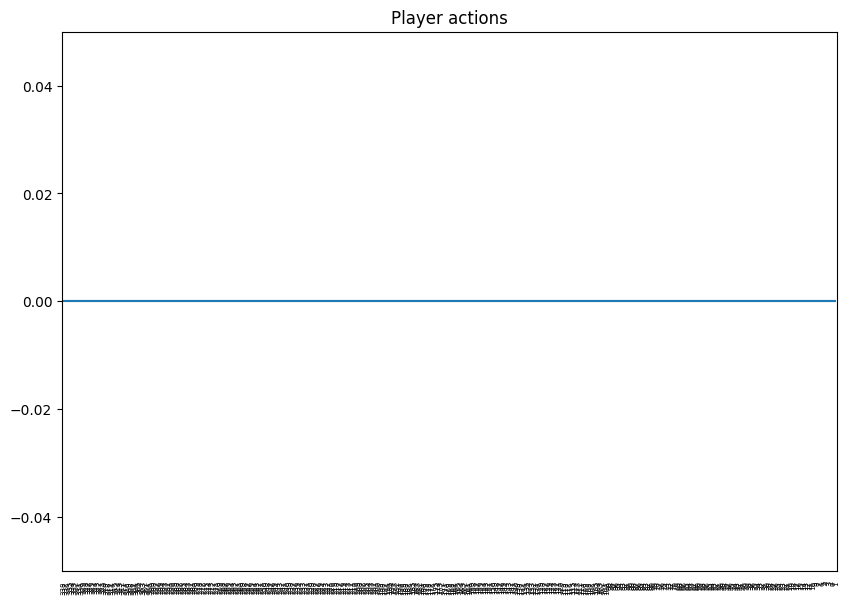

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc

# Lire le fichier CSV en tant que DataFrame
df = pd.read_csv('TEST.CSV', delimiter=',', low_memory=False)

# Séparer les colonnes numériques des colonnes non numériques
numeric_cols = df.select_dtypes(include=[np.number]).columns
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns

# Remplacer les valeurs infinies par NaN dans les colonnes numériques
df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)

# Remplacer les NaN par la moyenne de la colonne dans les colonnes numériques
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Pour les colonnes non numériques, remplacer les NaN par une chaîne vide ou une autre valeur appropriée
df[non_numeric_cols] = df[non_numeric_cols].fillna('')

# Convertir le DataFrame en tableau NumPy en ne prenant que les colonnes numériques pour le clustering
data = df[numeric_cols].to_numpy()

# Vérifiez si toutes les valeurs sont finies maintenant
print(np.all(np.isfinite(data)))

# Générer le dendrogramme
plt.figure(figsize=(10, 7))
plt.title("Player actions")
dend = shc.dendrogram(shc.linkage(data, method='ward'))
plt.show()




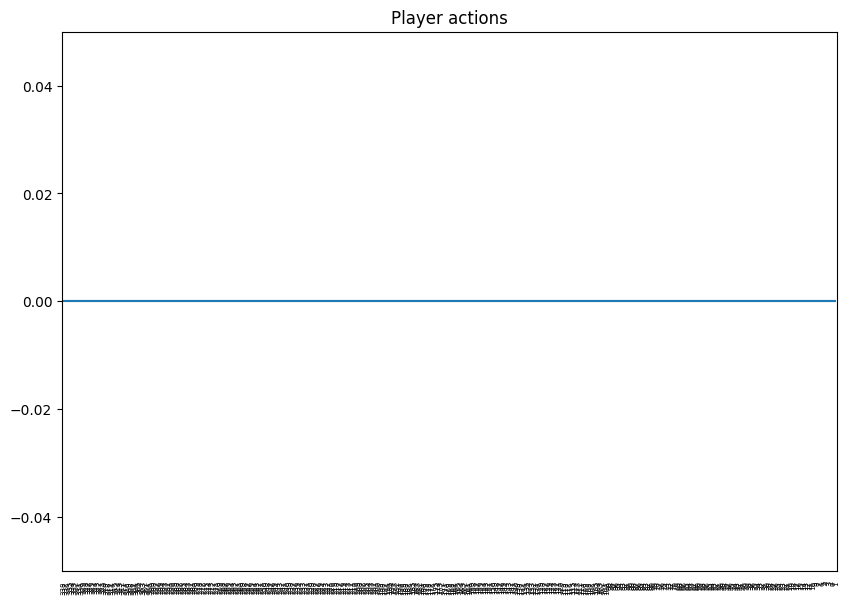

In [29]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Player actions")
dend = shc.dendrogram(shc.linkage(data, method='ward'))
plt.show()





True


/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:2844: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])


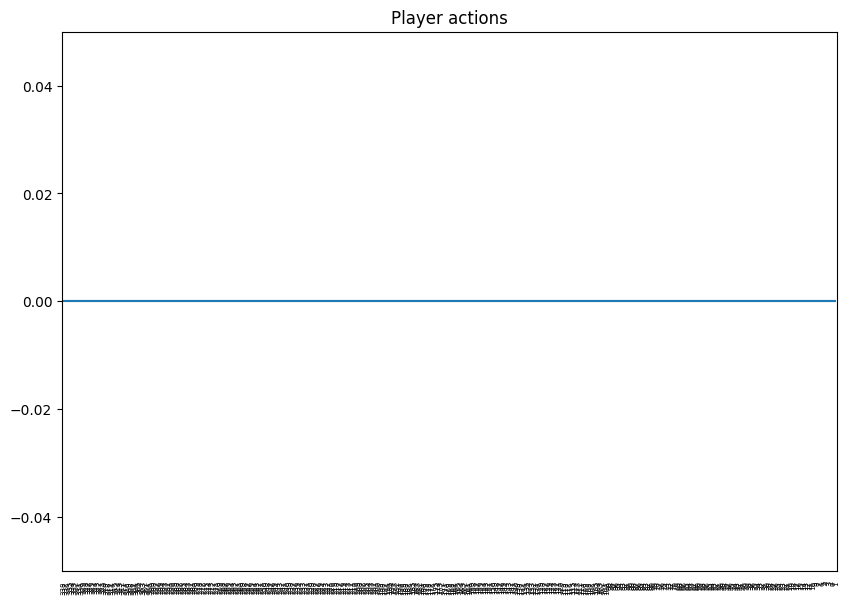

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc

# Lire le fichier CSV en tant que DataFrame
df = pd.read_csv('TEST.CSV', delimiter=',', low_memory=False)

# Séparer les colonnes numériques des colonnes non numériques
numeric_cols = df.select_dtypes(include=[np.number]).columns
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns

# Remplacer les valeurs infinies par NaN dans les colonnes numériques
df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)

# Remplacer les NaN par la moyenne de la colonne dans les colonnes numériques
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Pour les colonnes non numériques, remplacer les NaN par une chaîne vide ou une autre valeur appropriée
df[non_numeric_cols] = df[non_numeric_cols].fillna('')

# Convertir le DataFrame en tableau NumPy en ne prenant que les colonnes numériques pour le clustering
data = df[numeric_cols].to_numpy()

# Vérifiez si toutes les valeurs sont finies maintenant
print(np.all(np.isfinite(data)))

# Générer le dendrogramme
plt.figure(figsize=(10, 7))
plt.title("Player actions")
dend = shc.dendrogram(shc.linkage(data, method='ward'))
plt.show()


In [31]:
#partie jouée par chaque jouer
players=train_dataset.groupby('Player').Player.count().reset_index(name='count').sort_values('count',ascending=False)
players.head()

Player  count
19  http://eu.battle.net/sc2/en/profile/3074362/1/...     23
25  http://eu.battle.net/sc2/en/profile/3538115/1/...     22
16  http://eu.battle.net/sc2/en/profile/2896854/1/...     21
27  http://eu.battle.net/sc2/en/profile/3973341/1/...     21
23  http://eu.battle.net/sc2/en/profile/3368730/1/...     17

In [32]:
max_games=players[players['count']==players['count'].min()]
l=max_games['Player'].values

In [33]:
player_with_max_games= train_dataset['Player'] ==l[0]
train_dataset[player_with_max_games]

Player  Race          s  \
343  http://eu.battle.net/sc2/en/profile/219517/1/T...  Zerg  56.239316   
345  http://eu.battle.net/sc2/en/profile/219517/1/T...  Zerg  59.071429   
347  http://eu.battle.net/sc2/en/profile/219517/1/T...  Zerg  63.448819   

         Base  SingleMineral  hotkey00  hotkey01  hotkey02  hotkey10  \
343  0.273504       0.034188       0.0       0.0       0.0  0.547009   
345  0.857143       0.000000       0.0       0.0       0.0  0.214286   
347  0.755906       0.000000       0.0       0.0       0.0  0.236220   

     hotkey11  ...  m_f_hotkey62  m_f_hotkey70  m_f_hotkey71  m_f_hotkey72  \
343  1.435897  ...           0.0           0.0           0.0           0.0   
345  1.035714  ...           0.0           0.0           0.0           0.0   
347  1.086614  ...           0.0           0.0           0.0           0.0   

     m_f_hotkey80  m_f_hotkey81  m_f_hotkey82  m_f_hotkey90  m_f_hotkey91  \
343           0.0           0.0           0.0           0.0           0.0   
345           0.0           0.0           0.0           0.0           0.0   
347           0.0           0.0           0.0           0.0           0.0   

     m_f_hotkey92  
343      1.333333  
345      1.500000  
347      1.937008  

[3 rows x 70 columns]

array([[<Axes: title={'center': 's'}>, <Axes: title={'center': 'Base'}>,
        <Axes: title={'center': 'SingleMineral'}>,
        <Axes: title={'center': 'hotkey00'}>,
        <Axes: title={'center': 'hotkey01'}>,
        <Axes: title={'center': 'hotkey02'}>,
        <Axes: title={'center': 'hotkey10'}>,
        <Axes: title={'center': 'hotkey11'}>],
       [<Axes: title={'center': 'hotkey12'}>,
        <Axes: title={'center': 'hotkey20'}>,
        <Axes: title={'center': 'hotkey21'}>,
        <Axes: title={'center': 'hotkey22'}>,
        <Axes: title={'center': 'hotkey30'}>,
        <Axes: title={'center': 'hotkey31'}>,
        <Axes: title={'center': 'hotkey32'}>,
        <Axes: title={'center': 'hotkey40'}>],
       [<Axes: title={'center': 'hotkey41'}>,
        <Axes: title={'center': 'hotkey42'}>,
        <Axes: title={'center': 'hotkey50'}>,
        <Axes: title={'center': 'hotkey51'}>,
        <Axes: title={'center': 'hotkey52'}>,
        <Axes: title={'center': 'hotkey60'}>,


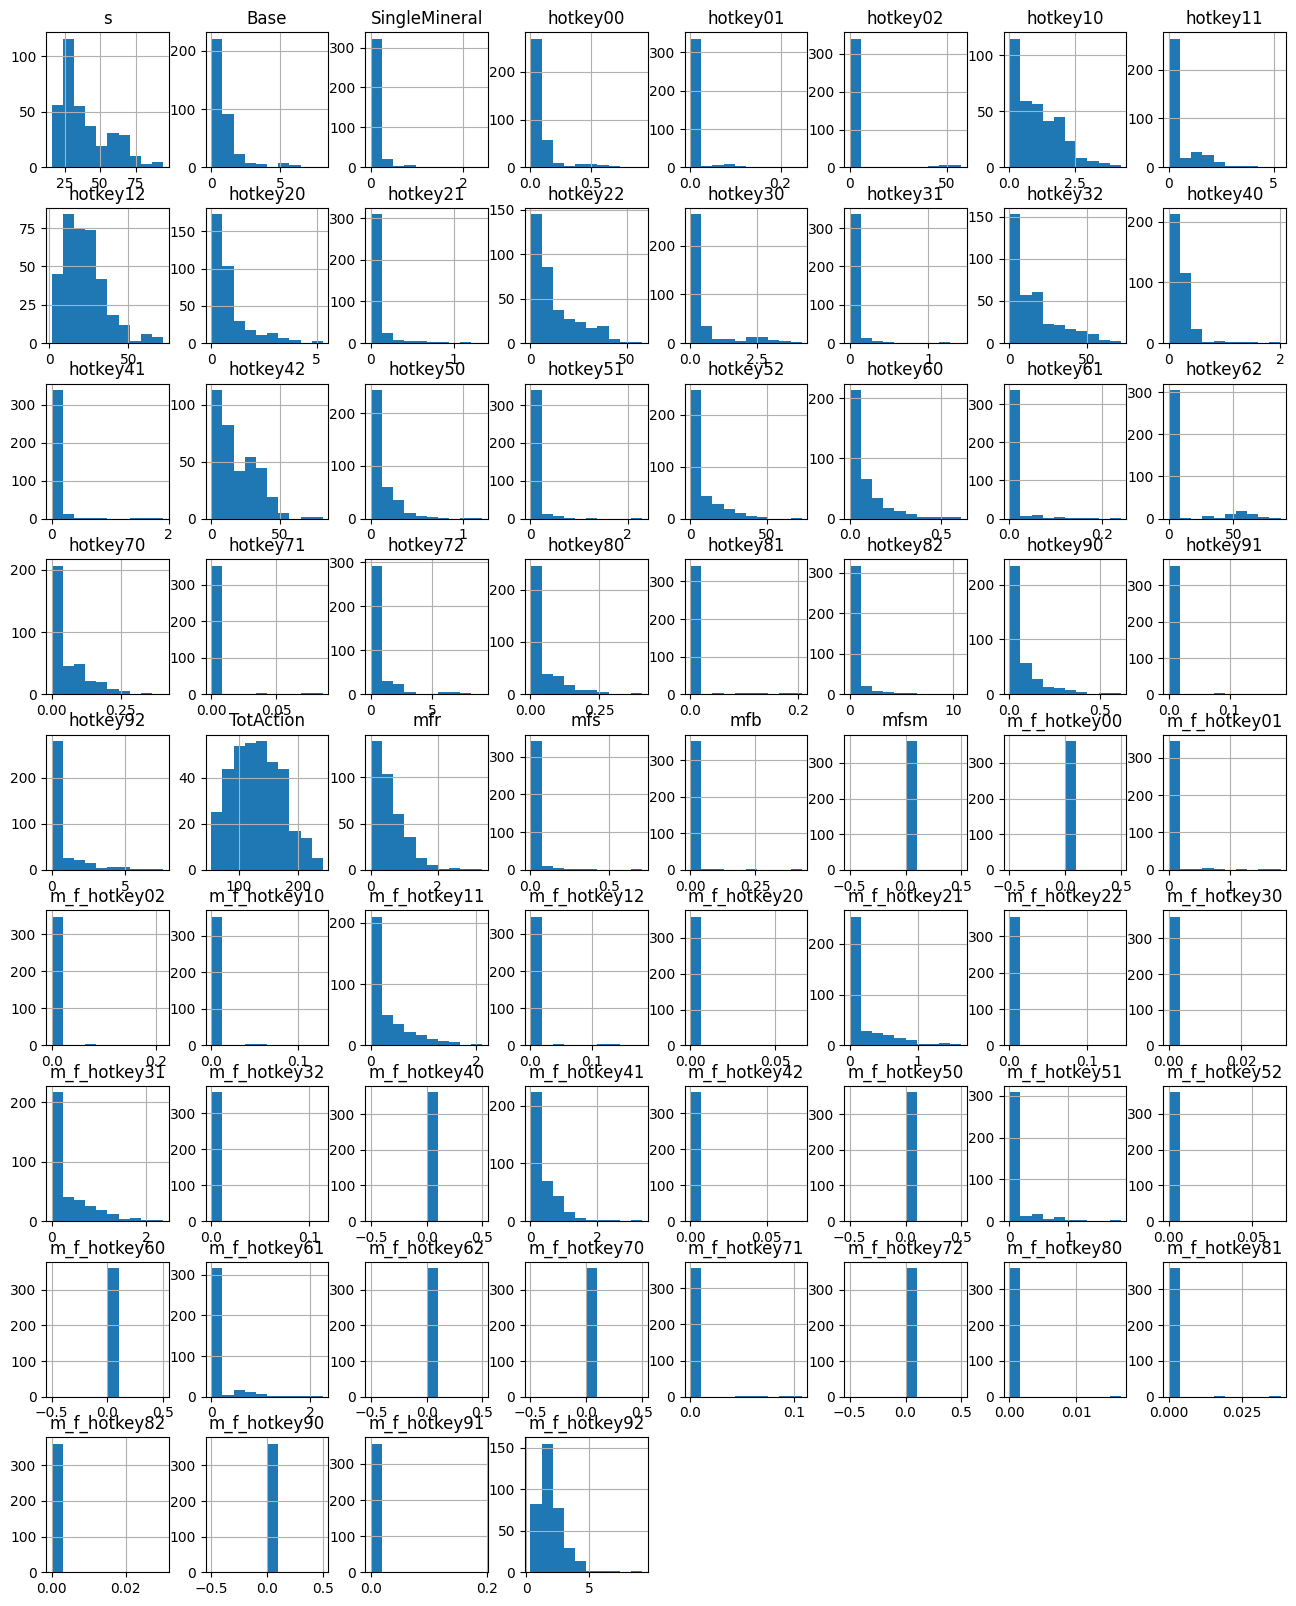

In [34]:
train_dataset.hist(figsize = (16,20), stacked= False)

In [35]:
train_dataset['Player'] = train_dataset['Player'].apply( lambda x : int(str(x).split('/')[6]))

In [36]:
import pandas as pd

# Lire le fichier CSV en ignorant les lignes mal formatées
train_dataset = pd.read_csv('TRAIN.CSV', delimiter=',', low_memory=False, on_bad_lines='skip')

# Afficher les premières lignes du DataFrame pour vérifier la lecture
print(train_dataset.head())




  http://eu.battle.net/sc2/en/profile/4234852/1/First/  Protoss  Base     s  \
0  http://eu.battle.net/sc2/en/profile/3074362/1/...    Protoss     s  Base   
1  http://eu.battle.net/sc2/en/profile/4234852/1/...    Protoss  Base     s   
2  http://eu.battle.net/sc2/en/profile/3074362/1/...    Protoss  Base     s   
3  http://eu.battle.net/sc2/en/profile/4234852/1/...    Protoss  Base     s   
4  http://eu.battle.net/sc2/en/profile/3074362/1/...    Protoss     s  Base   

  s.1   s.2   s.3 s.4        t5    Base.1  ... t1650 s.671 hotkey10.62 s.672  \
0   s     s  Base   s         s      Base  ...   NaN   NaN         NaN   NaN   
1   s     s  Base   s  hotkey30  hotkey00  ...   NaN   NaN         NaN   NaN   
2   s  Base     s   s         s        t5  ...   NaN   NaN         NaN   NaN   
3   s     s  Base   s  hotkey30  hotkey00  ...   NaN   NaN         NaN   NaN   
4   s     s  Base   s  hotkey30         s  ...   NaN   NaN         NaN   NaN   

  s.673 hotkey32.400 hotkey42.254 hotkey52.1

In [37]:
# Lire le fichier CSV ligne par ligne pour détecter les lignes mal formatées
with open('TRAIN.CSV', 'r') as file:
    lines = file.readlines()

expected_columns = 2565  # Remplacer par le nombre correct de colonnes attendu

for i, line in enumerate(lines):
    if len(line.split(',')) != expected_columns:
        print(f"Ligne {i + 1} problématique: {len(line.split(','))} colonnes")
        print(line)

# Après avoir identifié les lignes problématiques, vous pouvez les corriger manuellement ou automatiquement


Ligne 2 problématique: 2410 colonnes
http://eu.battle.net/sc2/en/profile/3074362/1/Stardust/,Protoss,s,Base,s,s,Base,s,s,Base,s,t5,hotkey30,s,hotkey32,s,hotkey32,s,hotkey32,s,hotkey32,s,hotkey32,t10,s,hotkey32,s,hotkey32,s,hotkey32,s,hotkey32,s,hotkey32,t15,s,hotkey32,s,hotkey32,s,t20,hotkey32,s,hotkey32,s,hotkey32,t25,s,hotkey32,s,hotkey32,s,hotkey32,s,t30,hotkey32,s,hotkey32,s,hotkey32,s,hotkey32,s,hotkey32,t35,s,hotkey32,s,hotkey32,t40,s,hotkey32,s,hotkey32,s,hotkey32,hotkey10,s,hotkey10,t45,hotkey32,hotkey12,hotkey32,hotkey12,hotkey32,s,hotkey32,s,t50,hotkey32,t55,s,hotkey32,s,hotkey32,s,hotkey32,hotkey12,hotkey32,s,hotkey32,t60,hotkey12,hotkey32,hotkey12,hotkey32,s,hotkey32,hotkey12,t65,hotkey32,s,hotkey32,hotkey12,hotkey32,hotkey12,hotkey32,s,hotkey32,hotkey12,hotkey32,t70,s,hotkey32,s,hotkey32,hotkey12,hotkey32,s,hotkey32,t75,s,hotkey32,hotkey12,hotkey32,s,hotkey32,hotkey12,hotkey32,t80,hotkey12,hotkey32,s,hotkey32,hotkey12,hotkey32,s,hotkey32,hotkey12,hotkey32,s,hotkey32,hotkey

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [38]:
import pandas as pd

try:
    train_dataset = pd.read_csv('TRAIN.CSV', delimiter=',', low_memory=False)
except pd.errors.ParserError as e:
    print(f"Erreur de parsing: {e}")

# Afficher les premières lignes du DataFrame pour vérifier la lecture
print(train_dataset.head())


Erreur de parsing: Error tokenizing data. C error: Expected 2565 fields in line 12, saw 3058

  http://eu.battle.net/sc2/en/profile/4234852/1/First/  Protoss  Base     s  \
0  http://eu.battle.net/sc2/en/profile/3074362/1/...    Protoss     s  Base   
1  http://eu.battle.net/sc2/en/profile/4234852/1/...    Protoss  Base     s   
2  http://eu.battle.net/sc2/en/profile/3074362/1/...    Protoss  Base     s   
3  http://eu.battle.net/sc2/en/profile/4234852/1/...    Protoss  Base     s   
4  http://eu.battle.net/sc2/en/profile/3074362/1/...    Protoss     s  Base   

  s.1   s.2   s.3 s.4        t5    Base.1  ... t1650 s.671 hotkey10.62 s.672  \
0   s     s  Base   s         s      Base  ...   NaN   NaN         NaN   NaN   
1   s     s  Base   s  hotkey30  hotkey00  ...   NaN   NaN         NaN   NaN   
2   s  Base     s   s         s        t5  ...   NaN   NaN         NaN   NaN   
3   s     s  Base   s  hotkey30  hotkey00  ...   NaN   NaN         NaN   NaN   
4   s     s  Base   s  hotkey30

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Lire le fichier CSV en ignorant les lignes mal formatées
train_dataset = pd.read_csv('TRAIN.CSV', delimiter=',', low_memory=False, on_bad_lines='skip')

# Remplacer les valeurs infinies par NaN
train_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

# Identifier les colonnes non numériques
non_numeric_cols = train_dataset.select_dtypes(include=['object']).columns

# Encoder les colonnes non numériques en valeurs numériques
label_encoders = {}
for col in non_numeric_cols:
    le = LabelEncoder()
    train_dataset[col] = le.fit_transform(train_dataset[col].astype(str))
    label_encoders[col] = le

# Remplacer les NaN par la moyenne de la colonne
train_dataset.fillna(train_dataset.mean(), inplace=True)

# Calculer la corrélation uniquement sur les colonnes numériques
numeric_cols = train_dataset.select_dtypes(include=[np.number]).columns
corr_matrix = train_dataset[numeric_cols].corr()

# Afficher la corrélation de la colonne 'Player' avec les autres colonnes numériques
if 'Player' in numeric_cols:
    player_corr = corr_matrix['Player']
    print(player_corr)
else:
    print("La colonne 'Player' n'est pas numérique ou n'existe pas dans le dataset.")


La colonne 'Player' n'est pas numérique ou n'existe pas dans le dataset.


In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Lire le fichier CSV en ignorant les lignes mal formatées
train_dataset = pd.read_csv('TRAIN.CSV', delimiter=',', low_memory=False, on_bad_lines='skip')

# Afficher les premières lignes du DataFrame pour vérifier la lecture
print(train_dataset.head())

# Afficher les colonnes disponibles dans le DataFrame
print(train_dataset.columns)

# Vérifier si la colonne 'Player' existe
if 'Player' in train_dataset.columns:
    print(f"Type de données de la colonne 'Player': {train_dataset['Player'].dtype}")

    # Si la colonne 'Player' n'est pas numérique, la convertir
    if not np.issubdtype(train_dataset['Player'].dtype, np.number):
        le = LabelEncoder()
        train_dataset['Player'] = le.fit_transform(train_dataset['Player'].astype(str))
        print("La colonne 'Player' a été encodée.")

    # Remplacer les valeurs infinies par NaN
    train_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Remplacer les NaN par la moyenne de la colonne
    train_dataset.fillna(train_dataset.mean(), inplace=True)

    # Calculer la corrélation uniquement sur les colonnes numériques
    numeric_cols = train_dataset.select_dtypes(include=[np.number]).columns
    corr_matrix = train_dataset[numeric_cols].corr()

    # Afficher la corrélation de la colonne 'Player' avec les autres colonnes numériques
    player_corr = corr_matrix['Player']
    print(player_corr)
else:
    print("La colonne 'Player' n'existe pas dans le dataset.")


  http://eu.battle.net/sc2/en/profile/4234852/1/First/  Protoss  Base     s  \
0  http://eu.battle.net/sc2/en/profile/3074362/1/...    Protoss     s  Base   
1  http://eu.battle.net/sc2/en/profile/4234852/1/...    Protoss  Base     s   
2  http://eu.battle.net/sc2/en/profile/3074362/1/...    Protoss  Base     s   
3  http://eu.battle.net/sc2/en/profile/4234852/1/...    Protoss  Base     s   
4  http://eu.battle.net/sc2/en/profile/3074362/1/...    Protoss     s  Base   

  s.1   s.2   s.3 s.4        t5    Base.1  ... t1650 s.671 hotkey10.62 s.672  \
0   s     s  Base   s         s      Base  ...   NaN   NaN         NaN   NaN   
1   s     s  Base   s  hotkey30  hotkey00  ...   NaN   NaN         NaN   NaN   
2   s  Base     s   s         s        t5  ...   NaN   NaN         NaN   NaN   
3   s     s  Base   s  hotkey30  hotkey00  ...   NaN   NaN         NaN   NaN   
4   s     s  Base   s  hotkey30         s  ...   NaN   NaN         NaN   NaN   

  s.673 hotkey32.400 hotkey42.254 hotkey52.1

In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Lire le fichier CSV en ignorant les lignes mal formatées
train_dataset = pd.read_csv('TRAIN.CSV', delimiter=',', low_memory=False, on_bad_lines='skip')

# Afficher les premières lignes du DataFrame pour vérifier la lecture
print(train_dataset.head())

# Afficher les colonnes disponibles dans le DataFrame
print(train_dataset.columns)

# Identifier les colonnes non numériques
non_numeric_cols = train_dataset.select_dtypes(include=['object']).columns

# Encoder les colonnes non numériques en valeurs numériques
label_encoders = {}
for col in non_numeric_cols:
    le = LabelEncoder()
    train_dataset[col] = le.fit_transform(train_dataset[col].astype(str))
    label_encoders[col] = le

# Vérifier si la colonne 'Player' existe
if 'Player' in train_dataset.columns:
    # Remplacer les valeurs infinies par NaN
    train_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Remplacer les NaN par la moyenne de la colonne
    train_dataset.fillna(train_dataset.mean(), inplace=True)

    # Calculer la corrélation uniquement sur les colonnes numériques
    numeric_cols = train_dataset.select_dtypes(include=[np.number]).columns
    corr_matrix = train_dataset[numeric_cols].corr()

    # Afficher la corrélation de la colonne 'Player' avec les autres colonnes numériques
    player_corr = corr_matrix['Player']
    print(player_corr)
else:
    print("La colonne 'Player' n'existe pas dans le dataset.")


  http://eu.battle.net/sc2/en/profile/4234852/1/First/  Protoss  Base     s  \
0  http://eu.battle.net/sc2/en/profile/3074362/1/...    Protoss     s  Base   
1  http://eu.battle.net/sc2/en/profile/4234852/1/...    Protoss  Base     s   
2  http://eu.battle.net/sc2/en/profile/3074362/1/...    Protoss  Base     s   
3  http://eu.battle.net/sc2/en/profile/4234852/1/...    Protoss  Base     s   
4  http://eu.battle.net/sc2/en/profile/3074362/1/...    Protoss     s  Base   

  s.1   s.2   s.3 s.4        t5    Base.1  ... t1650 s.671 hotkey10.62 s.672  \
0   s     s  Base   s         s      Base  ...   NaN   NaN         NaN   NaN   
1   s     s  Base   s  hotkey30  hotkey00  ...   NaN   NaN         NaN   NaN   
2   s  Base     s   s         s        t5  ...   NaN   NaN         NaN   NaN   
3   s     s  Base   s  hotkey30  hotkey00  ...   NaN   NaN         NaN   NaN   
4   s     s  Base   s  hotkey30         s  ...   NaN   NaN         NaN   NaN   

  s.673 hotkey32.400 hotkey42.254 hotkey52.1

In [43]:
data = train_dataset.iloc[:, 2:].values

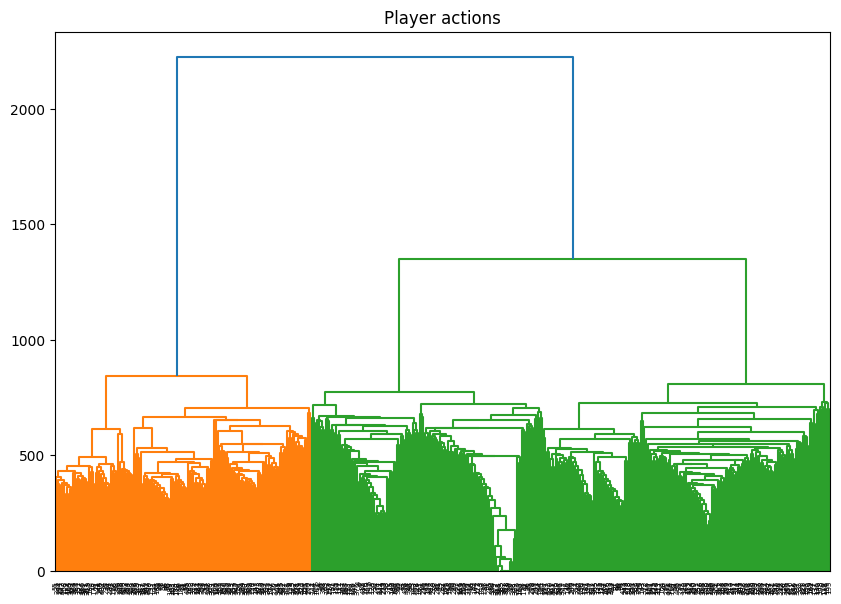

In [44]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title("Player actions")
dend = shc.dendrogram(shc.linkage(data, method='ward'))

In [ ]:
#partie jouée par chaque jouer
players=train_dataset.groupby('Player').Player.count().reset_index(name='count').sort_values('count',ascending=False)
players.head()

Il est observé que le nombre de parties jouées varie de 4 à 58, ce qui suggère que le joueur ayant joué 58 parties est celui qui est arrivé en finale et l'a remportée.
Il est important de noter que le même joueur pourrait posséder plus d'un label.

In [46]:
max_games=players[players['count']==players['count'].min()]
l=max_games['Player'].values

In [ ]:
player_with_max_games= train_dataset['Player'] ==l[0]
train_dataset[player_with_max_games]

array([[<Axes: title={'center': 'http://eu.battle.net/sc2/en/profile/4234852/1/First/'}>,
        <Axes: title={'center': 'Protoss'}>,
        <Axes: title={'center': 'Base'}>, ...,
        <Axes: title={'center': 't60'}>,
        <Axes: title={'center': 'hotkey32.11'}>,
        <Axes: title={'center': 's.19'}>],
       [<Axes: title={'center': 'hotkey32.12'}>,
        <Axes: title={'center': 's.20'}>,
        <Axes: title={'center': 'hotkey32.13'}>, ...,
        <Axes: title={'center': 's.42'}>,
        <Axes: title={'center': 'hotkey32.34'}>,
        <Axes: title={'center': 's.43'}>],
       [<Axes: title={'center': 'hotkey32.35'}>,
        <Axes: title={'center': 's.44'}>,
        <Axes: title={'center': 'hotkey32.36'}>, ...,
        <Axes: title={'center': 's.63'}>,
        <Axes: title={'center': 'hotkey32.55'}>,
        <Axes: title={'center': 's.64'}>],
       ...,
       [<Axes: title={'center': 'hotkey12.336'}>,
        <Axes: title={'center': 's.631'}>,
        <Axes: title={

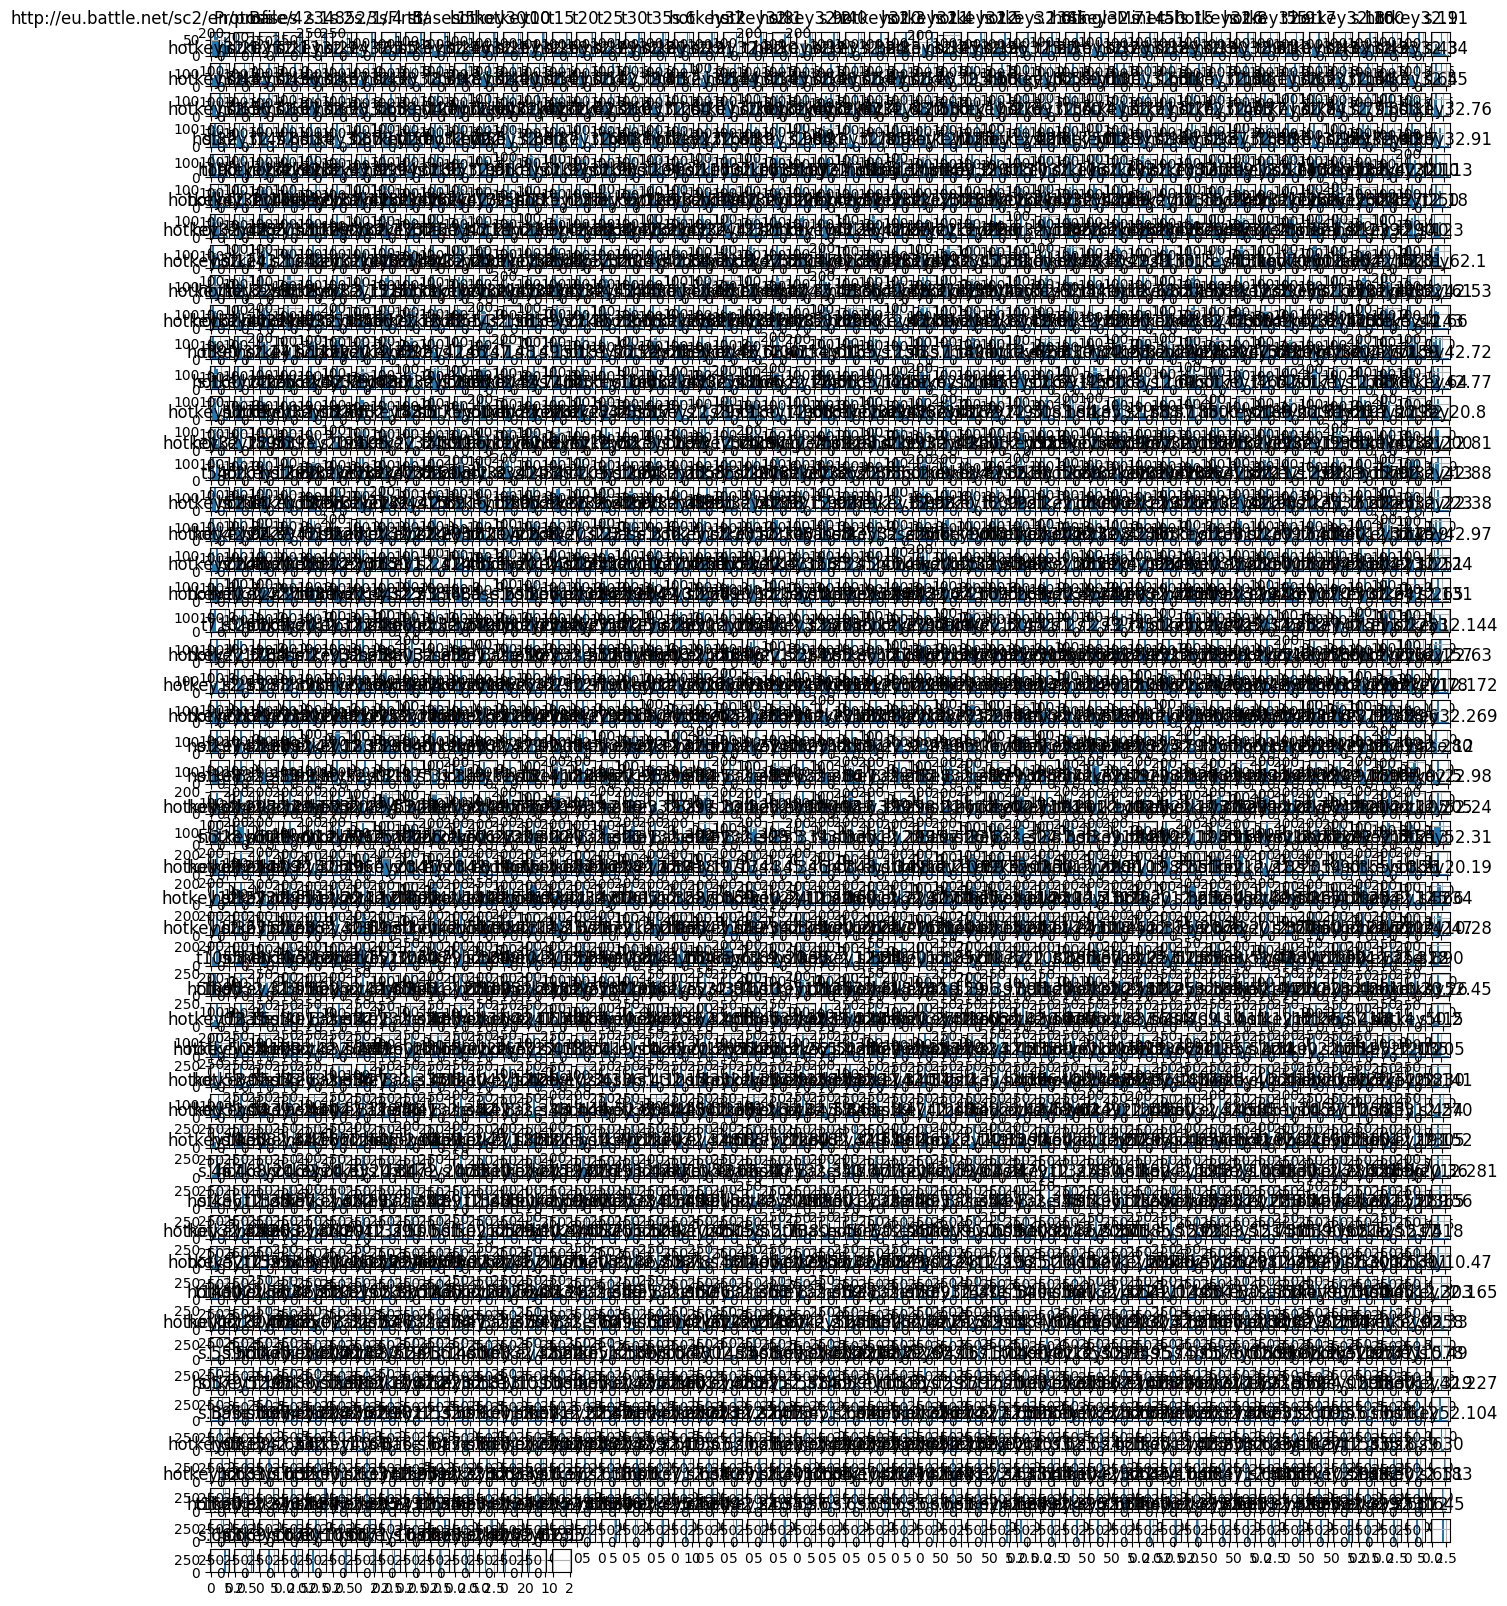

In [48]:
train_dataset.hist(figsize = (16,20), stacked= False)

In [ ]:
train_dataset['Player'] = train_dataset['Player'].apply( lambda x : int(str(x).split('/')[6]))

In [ ]:
train_dataset.corr()['Player']

In [ ]:
#on essaye de se débarasser des données qui sont pas corrélées
serie = pd.Series(train_dataset.corr()['Player'])
attributs = list(serie[abs(serie) > 0.01].index)
attributs.remove('Player')
attributs.append('Race')
attributs

In [ ]:
corrMatt = train_dataset[attributs].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(40,20)
sn.heatmap(corrMatt, center = 0 ,cmap = "seismic",vmin=-1, vmax=1, square=True,annot=False)

In [ ]:
# Encodage
enc = preprocessing.LabelEncoder()
enc.fit(['Terran','Protoss','Zerg'])
test_dataset['Race']=enc.transform(test_dataset['Race'])
train_dataset['Race']=enc.transform(train_dataset['Race'])

In [ ]:
features =  train_dataset.loc[:, train_dataset.columns != 'Player']
features=pd.DataFrame(features)
#split la data pour le training et le testing
features_train , features_test, labels_train , labels_test = train_test_split(features, labels, test_size=0.3,random_state=42)

Hyperparameter tuning : MAX_DEPTH of decision tree classifier

In [ ]:
accuracy = []
best_accuracy=0
for i in range(1,100):
   #Initialiser notre model
    dtree = tree.DecisionTreeClassifier(max_depth=i)
    #training
    dtree.fit(features_train,labels_train)
    #testing
    Y_pred = dtree.predict(features_test)
    #Cross validation
    accuracy.append(int(accuracy_score(labels_test, Y_pred)*100))
    if (best_accuracy<(dtree.score(features_test,labels_test)*100)):
        best_accuracy=dtree.score(features_test,labels_test)*100
        best_depth=i

In [ ]:
#Initialiser notre model
dtree = tree.DecisionTreeClassifier(max_depth=best_depth) #best depth
#training
dtree.fit(features_train,labels_train)
#testing
Y_pred = dtree.predict(features_test)
#Cross validation
print(f'accuracy of our decision tree model is around : {dtree.score(features_test,labels_test)*100} %' )

In [ ]:
# plot accuracy
fig = plt.figure(figsize = (10, 5))
title = fig.suptitle("Decision Tree Accuracy", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1,1, 1)
ax.set_xlabel("Max depth")
ax.set_ylabel("Accuracy")
ac = ([i for i in range(1,100)], accuracy)
ax.tick_params(axis='both', which='major', labelsize=8.5)
bar = ax.bar(ac[0], ac[1], color='steelblue',
        edgecolor='black', linewidth=1)

In [ ]:
#on essaye de tracer la matrice de confusion pour decision tree
mat=confusion_matrix(labels_test,Y_pred)
pd.DataFrame(normalize(mat,axis=1))

In [ ]:
#on fait le hHyperparameter tuning : n_estimators
for i in range(100,1001,50):
    classifier=ExtraTreesClassifier(n_estimators=i)
    classifier1=RandomForestClassifier(n_estimators=i)
    classifier.fit(features_train,labels_train)
    classifier1.fit(features_train,labels_train)
    print(f'accuracy of Extra trees classifier is around : {classifier.score(features_test,labels_test)*100:.2f} %' )
    print(f'accuracy of Random Forest is around : {classifier1.score(features_test,labels_test)*100:.2f} %' )
    print('*--------------------------------------------------------------------*')

On observe une certaine similarité entre les performances du EXTRA tree classifier et du Random forest, en raison de :

Dans un classificateur Extra Trees classifier, les caractéristiques et les divisions sont choisis au hasard, ce qui signifie "Tree Extrêmement Randomisé". Étant donné que les divisions sont sélectionnées de manière aléatoire pour chaque caractéristique du Extra Trees classé, le calcul est moins coûteux qu'avec Random Forest.


Le fonctionnement du Extra Trees a été similaire à celui du classificateur Random Forest. Toutefois, il existe des disparités de performance que je souhaite souligner. Il convient de noter que la variance du choix de l'arbre est élevée, celle du Random Forest est moyenne et celle de l'Extra Tree est faible.
